In [1]:
# warning: current data partitioning with label overrides assumes one object per image

# credit to: https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae
# for initial ideas

# installing key packages:
# conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch -c nvidia

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pycocotools
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from glob import glob
from skimage import transform

import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import pandas as pd
import random

from common import parse_kitti
import json
import numpy as np

In [4]:
class KITTIDataset(torch.utils.data.Dataset):
    
    def __init__(self, records, label_map, use_label_overrides=False, transforms=None):
        super().__init__()
        self.transforms = transforms
        self.records = records
        self.label_map = label_map
        self.use_label_overrides = use_label_overrides
        
        if (self.use_label_overrides):
            print("Warning, label overrides assume one object per image")
    
    def get_image_path(self, idx):
        return self.records[idx]['image_path']   
    
    def get_label_path(self, idx):
        return self.records[idx]['label_path']   
    
    def get_label_override(self, idx):
        return self.records[idx]['label_override']   
        
    def __getitem__(self, idx):
        
        try:
            # load images and bounding boxes        
            image_path = self.get_image_path(idx)
            label_path = self.get_label_path(idx)
            label_override = self.get_label_override(idx)

            img = Image.open(image_path).convert("RGB")
            objects = parse_kitti(label_path)                
            boxes = torch.tensor([o['bounds'] for o in objects], dtype=torch.float32)
            
            # relabel if needed
            if self.use_label_overrides:
                labels = torch.tensor([self.label_map[label_override] for o in objects], dtype=torch.int64)
            else:
                labels = torch.tensor([self.label_map[o['label']] for o in objects], dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = torch.tensor([idx])
            target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
            target["iscrowd"] = torch.zeros((len(objects),), dtype=torch.int64)            

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target
        
        except Exception as e:            
            print(self.records[idx])
            raise e
    
    def __len__(self):
        return len(self.records)

In [5]:
def get_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))        
    return T.Compose(transforms)

In [6]:
def get_model(num_classes, pretrained=False):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:
def display_annotation(image, target, label_map, prediction=None, thresh=0, size=None, title=""):
    
    # invert labelmap
    label_map = {v:k for k,v in label_map.items()}
    
    label_offset_x = 0
    label_offset_y = -2
    fig, ax = plt.subplots(figsize=size)   
    image = image.permute(1, 2, 0).cpu().numpy()
    
    # image resize
    #width, height, channels = image.shape
    #image = transform.resize(image, (2*width, 2*height))
    
    ax.imshow(image) # assumes image is a torch.tensor
    
    # ground truth
    boxes = target['boxes']    
    for i in range(boxes.size()[0]):
        x1, y1, x2, y2 = target['boxes'][i]
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')    
        ax.add_patch(rect)
        ax.text(x1 + label_offset_x, y1 + label_offset_y, f"{label_map[target['labels'][i].item()]}", color='r')
        if title:
            ax.set_title(title)
        
    # prediction
    if prediction:
        boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
        for i in range(boxes.size()[0]):            
            if scores[i] > thresh:
                x1, y1, x2, y2 = boxes[i]
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='g', facecolor='none')    
                ax.add_patch(rect)  
                text = f"{label_map[labels[i].item()]} {scores[i]:.2f}"
                ax.text(x1 + label_offset_x, y2 - 6*label_offset_y, text, color='g')
    plt.show()        

In [8]:
def load_partitions(pattern):
    parts = []
    paths = glob(pattern)
    for p in paths:
        with open(p, 'r') as f:
            parts.append(json.load(f))
    return parts

def train_test_partitions(parts, test_idx):
    p_test = parts[test_idx]
    p_train = []
    for i in range(len(parts)):
        if i != test_idx:
            p_train += parts[i]
    return p_train, p_test

# Data

In [9]:
# experiment name corresponds to the foldername and file prefix for data partitions and label maps
exp_name = "t1-extended"

# load train and test data partitions
pattern = f"{exp_name}/{exp_name}-part-*.json"
partitions = load_partitions(pattern)

test_fold = 3 # index of the test partition

data_train, data_test = train_test_partitions(partitions, test_fold)
print(f"folds: {len(partitions)}, test_fold: {test_fold}, train samples: {len(data_train)}, test samples: {len(data_test)}")

# load the label map
label_map_path = f"{exp_name}/{exp_name}-label-map.json"
with open(label_map_path, 'r') as f:
    label_map = json.load(f)
print(f"label map: {label_map}")
reverse_label_map = {v:k for k,v in label_map.items()}

use_label_overrides = True

folds: 5, test_fold: 3, train samples: 5413, test samples: 1356
label map: {'background': 0, 'rock': 1, 'artefact': 2}


In [10]:
#data_train = data_train[:100]

In [11]:
# define datasets and data loaders
batch_size = 32
ds = KITTIDataset(data_train, label_map, use_label_overrides=use_label_overrides, transforms=get_transforms(train=True))
ds_test = KITTIDataset(data_test, label_map, use_label_overrides=use_label_overrides, transforms=get_transforms(train=False))

dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=1, collate_fn=utils.collate_fn)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=1, shuffle=False, num_workers=1, collate_fn=utils.collate_fn)

Warning, label overrides assume one object per image
Warning, label overrides assume one object per image


### Data Review

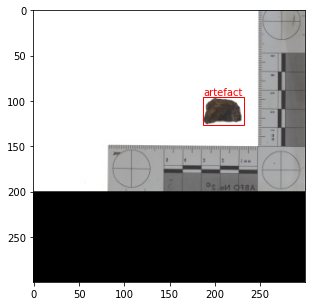

In [12]:
# check example training image
image, target = ds[random.randrange(len(ds))]
display_annotation(image, target, label_map, size=(5, 5))

In [13]:
# # check all images
# for i, path in enumerate(ds.img_paths):
#     image, target = ds[i]    
#     display_annotation(image, target, label_map, title=f"[{i}]: {path}")

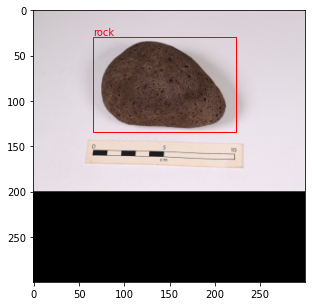

In [14]:
# check example test image
image, target = ds_test[random.randrange(len(ds_test))]
display_annotation(image, target, label_map, size=(5, 5))

In [15]:
# # check all test images
# for i in range(n_test):
#     image, target = ds_test[i]
#     display_annotation(image, target, label_map)

# Training

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
print('device:', device)

device: cuda


In [17]:
model = get_model(len(label_map)).to(device)

In [18]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
epochs = 10
logs = []
for e in range(epochs):    
    logger = train_one_epoch(model, optimizer, dl, device, e, print_freq=10, grad_clip=1)
    log_values = {k:{'median':v.median, 'mean':v.avg} for k,v in logger.meters.items()}
    logs.append(log_values)    
    # update the learning rate
    #lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, dl_test, device=device)

Epoch: [0]  [  0/170]  eta: 0:08:13  lr: 0.000007  loss: 1.8071 (1.8071)  loss_classifier: 1.0678 (1.0678)  loss_box_reg: 0.0378 (0.0378)  loss_objectness: 0.6957 (0.6957)  loss_rpn_box_reg: 0.0058 (0.0058)  time: 2.9039  data: 0.4772  max mem: 22331
Epoch: [0]  [ 10/170]  eta: 0:05:29  lr: 0.000066  loss: 1.3589 (1.2830)  loss_classifier: 0.6091 (0.6025)  loss_box_reg: 0.0487 (0.0450)  loss_objectness: 0.6905 (0.6294)  loss_rpn_box_reg: 0.0058 (0.0061)  time: 2.0571  data: 0.0948  max mem: 22757
Epoch: [0]  [ 20/170]  eta: 0:05:04  lr: 0.000125  loss: 0.6232 (0.8664)  loss_classifier: 0.2407 (0.4265)  loss_box_reg: 0.0546 (0.0672)  loss_objectness: 0.1530 (0.3668)  loss_rpn_box_reg: 0.0053 (0.0058)  time: 1.9859  data: 0.0597  max mem: 22757
Epoch: [0]  [ 30/170]  eta: 0:04:42  lr: 0.000184  loss: 0.3492 (0.7028)  loss_classifier: 0.1955 (0.3514)  loss_box_reg: 0.1107 (0.0877)  loss_objectness: 0.0352 (0.2577)  loss_rpn_box_reg: 0.0055 (0.0059)  time: 1.9981  data: 0.0632  max mem: 22

Epoch: [1]  [150/170]  eta: 0:00:39  lr: 0.001000  loss: 0.1062 (0.1039)  loss_classifier: 0.0338 (0.0337)  loss_box_reg: 0.0671 (0.0623)  loss_objectness: 0.0017 (0.0040)  loss_rpn_box_reg: 0.0025 (0.0039)  time: 1.9674  data: 0.0670  max mem: 22757
Epoch: [1]  [160/170]  eta: 0:00:19  lr: 0.001000  loss: 0.1171 (0.1049)  loss_classifier: 0.0349 (0.0337)  loss_box_reg: 0.0798 (0.0635)  loss_objectness: 0.0015 (0.0039)  loss_rpn_box_reg: 0.0026 (0.0038)  time: 1.9696  data: 0.0654  max mem: 22757
Epoch: [1]  [169/170]  eta: 0:00:01  lr: 0.001000  loss: 0.1161 (0.1050)  loss_classifier: 0.0335 (0.0338)  loss_box_reg: 0.0713 (0.0637)  loss_objectness: 0.0014 (0.0038)  loss_rpn_box_reg: 0.0027 (0.0038)  time: 1.8915  data: 0.0659  max mem: 22757
Epoch: [1] Total time: 0:05:32 (1.9566 s / it)
Epoch: [2]  [  0/170]  eta: 0:06:31  lr: 0.001000  loss: 0.1107 (0.1107)  loss_classifier: 0.0343 (0.0343)  loss_box_reg: 0.0714 (0.0714)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0032 (0

In [ ]:
# save logs
log_name = f"{exp_name}/{exp_name}-model-{test_fold}-logs.json"
with open(log_name, 'w') as f:
    json.dump(logs, f)    

In [ ]:
# plot log data
def plot_logs(logs):    
    median = []
    mean = []
    for i in range(len(logs)):        
        median.append({k:v['median'] for k,v in logs[i].items()})
        mean.append({k:v['mean'] for k,v in logs[i].items()})
    
    median = pd.DataFrame(median)
    mean = pd.DataFrame(mean)
    
    nr = len(median.columns)
    fig, axes = plt.subplots(nrows=nr, ncols=1, figsize=(9, 3*nr))
    for i, name in enumerate(median.columns):
        axes[i].set_title(name)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].plot(median[name].values, label='median')
        axes[i].plot(mean[name].values, label='mean')        
        axes[i].legend()
    plt.tight_layout()

In [ ]:
plot_logs(logs)

### Model Saving

In [ ]:
# save the model
model_path = f"{exp_name}/{exp_name}-model-{test_fold}.pt"
torch.save(model.state_dict(), model_path)

# Evaluation

In [ ]:
# load model
loaded_model = get_model(len(label_map))
loaded_model.load_state_dict(torch.load(model_path))
loaded_model = loaded_model.to(device)

In [ ]:
idx = random.randrange(len(ds_test))
image, target = ds_test[idx]


loaded_model.eval()
with torch.no_grad():
    pred = loaded_model([image.to(device)])    
    display_annotation(image, target, label_map, prediction=pred[0], thresh=0.8, size=(10, 10))
    labels, scores = pred[0]['labels'], pred[0]['scores']
    for i in range(labels.size()[-1]):
        print(reverse_label_map[labels[i].item()], "--", scores[i].item())

In [ ]:
def topn_acc(model, ds, reverse_label_map, n=1, debug=True):
    
    results = np.zeros(len(ds))
    
    model.eval()        
    with torch.no_grad():
        for idx in range(len(ds)):
            image, target = ds[idx]        
            pred = model([image.to(device)])                
            
            # sort predicitons by classifacation score
            labels, scores = pred[0]['labels'], pred[0]['scores']
            pred = list(zip(labels, scores))
            pred.sort(key=lambda x: x[1], reverse=True)
            
            true_label = reverse_label_map[target['labels'][0].item()]
            pred_labels = [reverse_label_map[l.item()] for l, s in pred]
            if debug:
                print(f"true: {true_label}, pred: {[f'{reverse_label_map[l.item()]}: {s:.2f}' for l, s in pred]}")
            
            if true_label in pred_labels[:n]:
                results[idx] = 1
                
    return results            

In [ ]:
n = 1
acc = topn_acc(loaded_model, ds_test, reverse_label_map, n=n, debug=False)
print(f"top{n}_acc: {acc.sum()/len(acc):.2f}, sample size: {len(ds_test)}")

In [ ]:
# Need IOU for top prediction

In [ ]:
# overall accuracy (warning - prints images)
limit = 10
randomise = True
reverse_label_map = {v:k for k,v in label_map.items()}
loaded_model.eval()
results = []

indices = list(range(len(ds_test)))
if randomise:
    random.shuffle(indices)
    
with torch.no_grad():
    for idx in indices[:limit]:
        image, target = ds_test[idx]        
        pred = loaded_model([image.to(device)])    
        display_annotation(image, target, label_map, prediction=pred[0], thresh=0.7, size=(10, 10))
        
        labels, scores = pred[0]['labels'], pred[0]['scores']
        pred = list(zip(labels, scores))
        pred.sort(key=lambda x: x[1], reverse=True)
        print(f"[{reverse_label_map[target['labels'][0].item()]}]")
        for l, s in pred:
            print(reverse_label_map[l.item()], s.item())            
        print()